In [1]:
''' 

Submitter : JESOON KANG, 20170937
Date : 2019. 10. 


    Assignment 4. 

-   -


'''
import matplotlib.pyplot as plt
import math
import numpy as np
import random

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms

import torchvision
import os


In [2]:
# predict Function. if h(x) returns >=0.5, set to 1. other cases, set to 0.
def predict(h, labels) :
    mount = len(h)
    correct = 0
    
    for i in range(0,mount) :
        if h[i] >= 0.5 :
            if labels[i] == 1 :
                correct +=1
        else :
            if labels[i] == 0 :
                correct +=1
    return correct * (1/mount)

#### Section 2 END ####

In [3]:

#### Section 1. #### This Section is bringed Data_import_ex.py file.

# Image Data import & resize

transform = transforms.Compose([#transforms.Resize((256,256)),  
                                transforms.Grayscale(),		# the code transforms.Graysclae() is for changing the size [3,100,100] to [1, 100, 100] (notice : [channel, height, width] )
                                transforms.ToTensor(),])

#train_data_path = 'relative path of training data set'
train_data_path = '../data/horse-or-human/train'
trainset = torchvision.datasets.ImageFolder(root=train_data_path, transform=transform)
# change the valuse of batch_size, num_workers for your program
# if shuffle=True, the data reshuffled at every epoch 
trainloader = torch.utils.data.DataLoader(trainset, batch_size=100, shuffle=True, num_workers=0)  


validation_data_path = '../data/horse-or-human/validation'
valset = torchvision.datasets.ImageFolder(root=validation_data_path, transform=transform)
# change the valuse of batch_size, num_workers for your program
valloader = torch.utils.data.DataLoader(valset, batch_size=100, shuffle=True, num_workers=0)  

#### Section 1 END ####


In [4]:

# sigmoid Function.
def sigmoid(z) :
    return 1 / (1 + torch.pow(math.e,-z)+0.000001)

def tanh(z) :
    ret = (2 / (1 + torch.pow(math.e,-2*z) + 0.000001)) - 1
    return ret

def derv_tanh(z) :
    ret = (1 - (tanh(z)**2))
    return ret

def relu(z) :
    ret = z.clone().detach()
    tmp = torch.zeros_like(ret)
    ret = torch.where(ret<=0,tmp,ret)
    return ret
                                                                  
def derv_relu(z) :
    ret = z.clone().detach()
    tmp_1 = torch.zeros_like(ret)
    tmp_2 = torch.ones_like(ret)
    ret = torch.where(ret<=0,tmp_1,tmp_2)
    #print(ret)
    return ret
    
            
def leakly_relu(z) :
    ret = z.clone().detach()
    ret= np.where(ret <=0, 0.01*ret,ret )
    ret = torch.FloatTensor(ret)
    
    return ret

def derv_leakly_relu(z) :
    ret = z.clone().detach()
    ret = np.where(ret<=0,0.01,1)
    return ret

def get_activation(z,type) :
    if (type == 0) :
        return sigmoid(z)
    elif (type == 1) :
        return tanh(z)
    elif (type == 2) :
        return relu(z)
    elif (type == 3) :
        return leakly_relu(z)
    
    else :
        print("Error, get_activation")
        return 0

def get_derv_activation(z,type) :
    if (type == 0) :
        return sigmoid(z)*(1-sigmoid(z))
    elif (type == 1) :
        return derv_tanh(z)
    elif (type == 2) :
        return derv_relu(z)
    elif (type == 3) :
        return derv_leakly_relu(z)    
    else :
        print("Error, get_derv_activation")
        return 0                                                                  

In [24]:
def get_loss(y,a) :
    #print(y,a)
    ret = -(torch.div(y,a+0.000001) - torch.div(1-y,1-a+0.000001))
    
    return ret

BATCH_SIZE = 100
FEATURE_SIZE = 10000
class ML :
    def __init__(self,act1,act2,act3,L1_size,L2_size,L3_size,lr,min_loss_diff) :
        self.act_type_1 = act1
        self.act_type_2 = act2
        self.act_type_3 = act3
        
        self.l1_size = L1_size
        self.l2_size = L2_size
        self.l3_size = L3_size
        self.feature_size = 10000
        self.batch_size = 256
        self.t_batch_idx = 0
        self.epoch = 0
        self.lr = lr
        self.min_loss_diff = min_loss_diff
        
        self.init_weights()
        
        print("ML Object initialized")
        self.iter = 0

        self.val_acc_log = []
        self.val_loss_log = []
        self.train_acc_log = []
        self.train_loss_log = []
        self.epoch_log = []
        self.val_acc_log.append(0)
        self.val_loss_log.append(0)
        self.train_acc_log.append(0)
        self.train_loss_log.append(0)
        self.epoch_log.append(0)
        
    def init_weights(self) :
        self.w_1 = torch.FloatTensor(self.l1_size,self.feature_size).uniform_(-1,1)
        self.b_1 = torch.FloatTensor(1,self.l1_size).uniform_(-1,1)
        
        #torch.FloatTensor(a, b).uniform_(r1, r2)
        
        self.w_2 = torch.FloatTensor(self.l2_size,self.l1_size).uniform_(-1,1)
        self.b_2 = torch.FloatTensor(1,self.l2_size).uniform_(-1,1)

        self.w_3 = torch.FloatTensor(self.l3_size,self.l2_size).uniform_(-1,1)
        self.b_3 = torch.FloatTensor(1,self.l3_size).uniform_(-1,1)

        

        
    def training(self) :
        
        epoch = 0
        for epoch in range(0,1000000):
            train_acc_log_tmp = []
            train_loss_log_tmp = []
            val_acc_log_tmp = []
            val_loss_log_tmp = []
            

        # load training images of the batch size for every iteration
            for i, data in enumerate(trainloader):
                
                # inputs is the images
                # labels is the class of the image
                inputs, labels = data
                inputs, labels = inputs.float() , labels.float()
                # if you don't change the image size, it will be [batch_size, 1, 100, 100]

                # if labels is horse it returns tensor[0,0,0] else it returns tensor[1,1,1]
                
                self.t_data_batch = torch.squeeze(torch.FloatTensor(data[0]),3)
                
                self.t_data_batch = self.t_data_batch.view(len(data[0]),FEATURE_SIZE)
                self.z_1 = torch.matmul(self.t_data_batch,self.w_1.T) + self.b_1

                self.a_1 = get_activation(self.z_1,self.act_type_1)
                #print(self.a_1)

                self.z_2 = torch.matmul(self.a_1,self.w_2.T) + self.b_2
                self.a_2 = get_activation(self.z_2,self.act_type_2) # 1027 x 50

                self.z_3 = torch.matmul(self.a_2,self.w_3.T) + self.b_3
                self.a_3 = get_activation(self.z_3,self.act_type_3) # 1027 x 1

                self.t_yh_batch = data[1].float().unsqueeze(1)

                #print(self.a_3,self.t_yh_batch)
                acc = self.get_acc(self.a_3,self.t_yh_batch)
                loss = np.array(get_loss(self.t_yh_batch, self.a_3)).mean()
                
                train_acc_log_tmp.append(acc)
                train_loss_log_tmp.append(loss)
                
                self.update_weights(self.t_yh_batch,self.a_3)
            
            
            
            train_acc = np.array(train_acc_log_tmp).mean()
            train_loss = np.array(train_loss_log_tmp).mean()

            print("epoch : %s, loss : %s, tra_acc : %s"%(epoch,train_loss,train_acc))
            
           

            # load validation images of the batch size for every iteration
            for i, data in enumerate(valloader):

                # inputs is the image
                # labels is the class of the image
                inputs, labels = data
                inputs, labels = inputs.float() , labels.float()
                # if you don't change the image size, it will be [batch_size, 1, 100, 100]
                
                
                # if labels is horse it returns tensor[0,0,0] else it returns tensor[1,1,1]
                
                self.v_data_batch = torch.squeeze(torch.FloatTensor(data[0]),3)
                
                self.v_data_batch = self.v_data_batch.view(len(data[0]),FEATURE_SIZE)
                
                self.z_1 = torch.matmul(self.v_data_batch,self.w_1.T) + self.b_1

                self.a_1 = get_activation(self.z_1,self.act_type_1)
                

                self.z_2 = torch.matmul(self.a_1,self.w_2.T) + self.b_2
                self.a_2 = get_activation(self.z_2,self.act_type_2) # 1027 x 50

                self.z_3 = torch.matmul(self.a_2,self.w_3.T) + self.b_3
                self.a_3 = get_activation(self.z_3,self.act_type_3) # 1027 x 1

                self.v_yh_batch = data[1].float().unsqueeze(1)
                acc = self.get_acc(self.a_3,self.v_yh_batch)
                
                
                loss = np.array(get_loss(self.v_yh_batch, self.a_3)).mean()
                val_acc_log_tmp.append(acc)
                val_loss_log_tmp.append(loss)
            val_acc = np.array(val_acc_log_tmp).mean()
            val_loss = np.array(val_loss_log_tmp).mean()
            
            print("epoch : %s, loss : %s, val_acc : %s"%(epoch,val_loss,val_acc))

            self.train_acc_log.append(train_acc)
            self.train_loss_log.append(train_loss)
            self.val_acc_log.append(val_acc)
            self.val_loss_log.append(val_loss)
            self.epoch_log.append(epoch)
            epoch += 1
            
            tmp_idx = len(self.train_loss_log)-1
            if ( abs(self.train_loss_log[tmp_idx]-self.train_loss_log[tmp_idx-1]) < self.min_loss_diff) :
                print("Learning is terminated.")
                break

        
    def update_weights(self,t_y,a_3) :
        error_wb3 = -(torch.div(t_y,a_3) - torch.div(1.0-t_y,1.0-a_3)) # sum ep
        d_z_3 = error_wb3*get_derv_activation(self.z_3,self.act_type_3) #         
        d_w_3 = torch.matmul(d_z_3.T,self.a_2)
        d_b_3 = torch.sum(d_z_3, dim=0, keepdim=True) / self.a_2.shape[0] # mean도 됨
        
        #########
        
        error_wb2 = torch.matmul(d_z_3,self.w_3)
        
        d_z_2 = error_wb2*get_derv_activation(self.z_2,self.act_type_2)
        
        d_w_2 = torch.matmul(d_z_2.T,self.a_1)
        d_b_2 = torch.sum(d_z_2, dim=0,keepdims=True) / self.a_1.shape[0]
        
   
        error_wb1 = torch.matmul(d_z_2,self.w_2)
        d_z_1 = error_wb1*get_derv_activation(self.z_1,self.act_type_1)
        d_w_1 = torch.matmul(d_z_1.T,self.t_data_batch)
        d_b_1 = torch.sum(d_z_1, dim=0,keepdims=True) / self.t_data_batch.shape[0]
        
        self.w_3 += -self.lr*d_w_3
        self.b_3 += -self.lr*d_b_3
        
        self.w_2 += -self.lr*d_w_2
        self.b_2 += -self.lr*d_b_2
        self.w_1 += -self.lr*d_w_1
        self.b_1 += -self.lr*d_b_1
        #print(b_3,b_2,b_1)
        
    def get_acc(self,yhat,y) :
        count = 0
      
        for a,b in zip(yhat,y) :
            if a >= 0.5 :
                if b == 1 :
                    count+=1
            else :
                if b == 0:
                    count +=1
        
        return count / len(yhat)

    def show_loss(self) :
        #print(self.train_loss_log)
        #print(self.val_loss_log)
        #print(self.epoch_log)
        
        tmp_1 = torch.tensor(self.train_loss_log)
        tmp_2 = torch.tensor(self.epoch_log)
       
        t1 = plt.plot(self.epoch_log,self.train_loss_log, color='orange',label='Training Loss')
        t2 = plt.plot(self.epoch_log,self.val_loss_log, color= 'red',label='Validation Loss')
        plt.title("Loss")
        plt.legend(['Training Loss','Validation Loss'])
        plt.show()
    def show_acc(self) :
        t1 = plt.plot(self.epoch_log,self.train_acc_log, color='orange',label='Training Acc')
        t2 = plt.plot(self.epoch_log,self.val_acc_log, color= 'red',label='Validation Acc')
        plt.title("Accuracy")
        plt.legend(['Training Acc','Validation Acc'])
        plt.show()



In [34]:

activation_type = 0 # 0 = sigmoid
learningRate = 0.0001
min_loss_diff = 0.0001
machine = ML(0,0,0,10,5,1,learningRate,min_loss_diff)





ML Object initialized


In [35]:
machine.training()

epoch : 0, loss : -0.30765688, tra_acc : 0.4685858585858586
epoch : 0, loss : -0.20652969, val_acc : 0.49452380952380953
epoch : 1, loss : -0.29143062, tra_acc : 0.4663973063973064
epoch : 1, loss : -0.25781068, val_acc : 0.4814285714285715
epoch : 2, loss : -0.27040055, tra_acc : 0.4685858585858586
epoch : 2, loss : -0.22398102, val_acc : 0.48666666666666664
epoch : 3, loss : -0.26820004, tra_acc : 0.4676767676767677
epoch : 3, loss : -0.15570313, val_acc : 0.4997619047619047
epoch : 4, loss : -0.29580688, tra_acc : 0.4544781144781144
epoch : 4, loss : -0.21018273, val_acc : 0.48404761904761906
epoch : 5, loss : -0.2430859, tra_acc : 0.4676767676767677
epoch : 5, loss : -0.14515157, val_acc : 0.49714285714285716
epoch : 6, loss : -0.21278141, tra_acc : 0.4701346801346802
epoch : 6, loss : -0.1436368, val_acc : 0.49452380952380953
epoch : 7, loss : -0.21021324, tra_acc : 0.46949494949494947
epoch : 7, loss : -0.14206712, val_acc : 0.4892857142857143
epoch : 8, loss : -0.22159857, tra_a

epoch : 68, loss : 0.015007081, tra_acc : 0.528956228956229
epoch : 68, loss : 0.1105152, val_acc : 0.4902380952380952
epoch : 69, loss : -0.0039718095, tra_acc : 0.5314141414141414
epoch : 69, loss : 0.02700618, val_acc : 0.5111904761904762
epoch : 70, loss : 0.036180668, tra_acc : 0.524949494949495
epoch : 70, loss : 0.0065848134, val_acc : 0.5164285714285715
epoch : 71, loss : 0.037854668, tra_acc : 0.5240404040404041
epoch : 71, loss : 0.04868932, val_acc : 0.5059523809523809
epoch : 72, loss : -0.0010896393, tra_acc : 0.5316835016835015
epoch : 72, loss : -0.0027164917, val_acc : 0.519047619047619
epoch : 73, loss : 0.008150651, tra_acc : 0.5332323232323233
epoch : 73, loss : 0.040104702, val_acc : 0.5085714285714286
epoch : 74, loss : 0.0496946, tra_acc : 0.5283164983164984
epoch : 74, loss : 0.051942814, val_acc : 0.5085714285714286
epoch : 75, loss : 0.009152684, tra_acc : 0.5375084175084175
epoch : 75, loss : 0.052502256, val_acc : 0.5059523809523809
epoch : 76, loss : -0.0103

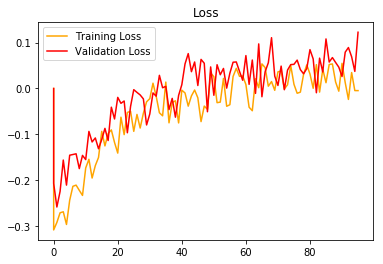

In [36]:
machine.show_loss()


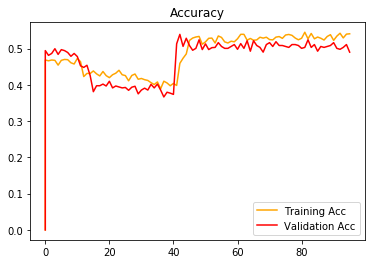

In [37]:
machine.show_acc()